# Pengerjaan Tugas Deep Learning menggunakan PyTorch and TensorFlow (Week 7, Dataset ReviewTokoBaju)

File ini memuat pelatihan model Bidirectional RNN dan Deep RNN, masing-masing menggunakan PyTorch dan TensorFlow, untuk dataset ReviewTokoBaju.csv

# Persiapan: Instalasi library dan Data Preprocessing

### 1. Memastikan Instalasi library

In [ ]:
# !pip install numpy matplotlib scikit-learn torch tensorflow tensorflow-datasets
# %pip install numpy matplotlib scikit-learn torch tensorflow tensorflow-datasets

### 2. Mengimpor Library yang Dibutuhkan

In [ ]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import SimpleRNN, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import json
import re
import string
import time
from copy import deepcopy

### 3. Mendefinisikan Parameter dan Pre-processing Dataset

In [ ]:
# Konstanta dan parameter
NUM_WORDS = 40000
MAXLEN = 100
BATCH_SIZE = 64
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1
EPOCHS = 20
LEARNING_RATE = 0.001

# Memeriksa apakah GPU tersedia
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {DEVICE}")

# Baca dataset
df = pd.read_csv('../ReviewTokoBaju.csv')

# Data Exploration
print(f"Dataset shape: {df.shape}")
print(df.head())
print(df.info())

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Fill missing values in 'Review Text' and 'Title'
df['Review Text'] = df['Review Text'].fillna('')
df['Title'] = df['Title'].fillna('')

# Combine Title and Review Text for better features
df['Combined_Text'] = df['Title'] + ' ' + df['Review Text']

# Target variable: 'Recommended IND' (0 or 1)
print("\nDistribution of Recommended IND:")
print(df['Recommended IND'].value_counts())

# Check correlation between Rating and Recommended IND
print("\nCorrelation between Rating and Recommended IND:")
print(df[['Rating', 'Recommended IND']].corr())

# Plot distribution of ratings
plt.figure(figsize=(10, 6))
plt.hist(df['Rating'], bins=10, color='blue', alpha=0.7)
plt.title('Distribution of Ratings by Recommendation')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# TensorFlow tokenizer
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Combined_Text'])
sequences = tokenizer.texts_to_sequences(df['Combined_Text'])
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')

X = pad_sequences(sequences, maxlen=MAXLEN, padding='post', truncating='post')
y = df['Recommended IND'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

# Untuk TensorFlow
train_data = (X_train, y_train)
test_data = (X_test, y_test)

# Mengonversi data ke tensor PyTorch
x_train_tensor = torch.tensor(X_train, dtype=torch.long).to(DEVICE)
x_test_tensor = torch.tensor(X_test, dtype=torch.long).to(DEVICE)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(DEVICE)


# Mengonversi data ke TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Membuat DataLoader untuk pelatihan, validasi, dan pengujian
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Menggunakan device: cpu
Cuplikan data JSON yang tidak terformat:
{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0}
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "is_sarcastic": 0}
{"article_link": "https://local.theonion.com/mom-starti

Cuplikan data JSON yang sudah diformat:
[{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0},
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny poli

### 4. Menyiapkan Fungsi Pelatihan dan Validasi

In [ ]:
# Fungsi untuk melatih model PyTorch
def train_model_pt(model, train_loader, criterion, optimizer, device, epochs, model_name):
    model.train()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    history = {'accuracy': [], 'loss': [], 'val_accuracy': [], 'val_loss': []}
    best_epoch = 0
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.float().to(device).view(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs.data > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
        train_accuracy = correct / total
        train_loss = train_loss / (batch_idx + 1)
        
        # Validasi
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.to(device), targets.float().to(device).view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                predicted = (outputs.data > 0.5).float()
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        val_accuracy = val_correct / val_total
        val_loss = val_loss / (batch_idx + 1)
        
        history['accuracy'].append(train_accuracy)
        history['loss'].append(train_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
            
        # Simpan model terbaik berdasarkan loss validasi
        if val_loss < min(history['val_loss'][:-1], default=float('inf')):
            print(f"Checkpoint: Model disimpan sebagai 'model_pytorch_{model_name}.pth' (validation loss terendah = {val_loss:.4f})")
            best_epoch = epoch + 1
            best_val_loss = val_loss
            torch.save(deepcopy(model.state_dict()), f'model_pytorch_{model_name}.pth')
        
        # Pelatihan diakhiri lebih awal jika tidak ada perbaikan dalam 5 epoch terakhir
        if len(history['val_loss']) > 7 and all(x > best_val_loss for x in history['val_loss'][-7:]):
            print("Early stopping: Tidak ada perbaikan dalam 5 epoch terakhir.")
            break
    
    print(f"Pelatihan selesai. Model terbaik pada epoch = {best_epoch}, dengan validation loss = {best_val_loss} disimpan.")
    return history

In [ ]:
# Fungsi untuk melatih model TensorFlow
def train_model_tf(model, train_data, model_name):
    x_train, y_train = train_data
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=f'model_tensorflow_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    print(f"Memulai pelatihan model {model_name}...")
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        shuffle=True,
        callbacks=callbacks,
        verbose=1
    )
    
    end_time = time.time()
    training_time = end_time - start_time
    mins, secs = divmod(training_time, 60)
    print(f"Waktu pelatihan: {int(mins)}m {int(secs)}s")
    
    return history

### 5. Menyiapkan Fungsi Evaluasi

In [ ]:
# Fungsi untuk evaluasi model PyTorch
def evaluate_model_pt(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    test_loss = 0
    all_preds = []
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data).squeeze(1)
            test_loss += criterion(output, target).item()
            
            pred = (output > 0.5).float()
            all_probs.extend(output.cpu().numpy())
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_loss /= len(test_loader)
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    
    # Menghitung ROC curve dan AUC
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)
    
    results = {
        'loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred': all_preds,
        'y_pred_prob': all_probs
    }
    
    return results

In [ ]:
# Fungsi untuk evaluasi model TensorFlow
def evaluate_model_tf(model, test_data, model_name):
    x_test, y_test = test_data
    
    # Prediksi
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Menghitung ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Print hasil evaluasi
    print(f"\nEvaluasi Model {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred,
        'y_test': y_test
    }

### 6. Menyiapkan Fungsi Visualisasi

In [ ]:
# Fungsi untuk membuat visualisasi hasil
# Fungsi untuk membuat visualisasi training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    best_epoch = history['val_loss'].index(min(history['val_loss']))
    best_val_loss = min(history['val_loss'])

    # Plot Loss, dengan tanda pada titik terbaik
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Valid Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=best_val_loss, color='g', linestyle='--', label='Best Val Loss')
    plt.title(f'{model_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Valid Accuracy')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=history['val_accuracy'][best_epoch], color='g', linestyle='--', label='Val Accuracy at Best Model')
    plt.title(f'{model_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_pytorch_{model_name}.png')
    plt.show()

# Fungsi untuk membuat ROC curve
def plot_roc_curve(results_dict):
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve_comparison_pytorch.png')
    plt.show()

# Fungsi untuk membuat bar chart perbandingan metrik
def plot_metrics_comparison(results_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    models = list(results_dict.keys())
    
    values = {metric: [results_dict[model][metric] for model in models] for metric in metrics}
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[metric], bar_width, 
                label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison')
    plt.xticks(index + bar_width * 2, models)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('metrics_comparison_pytorch.png')
    plt.show()


# Model DeteksiSarkasme Menggunakan Module PyTorch

## A. Model Bidirectional RNN Menggunakan PyTorch

### 1. Menyusun Model Bidirectional RNN


In [ ]:
# Definisi Model RNN
class BiRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BiRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim, bidirectional=True, batch_first=True, num_layers=2)
        self.rnn2 = nn.RNN(hidden_dim, hidden_dim // 2, bidirectional=True, batch_first=True, num_layers=2)
        self.rnn3 = nn.RNN(hidden_dim, hidden_dim // 2, batch_first=True, num_layers=2)
            
        self.fc = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):
        embedded = self.embedding(text)
        
        output1, hidden1 = self.rnn1(embedded)
        output2, hidden2 = self.rnn2(output1)
        output3, hidden3 = self.rnn3(output2)
        hidden = hidden3[-1, :, :]
            
        dropout_out = self.dropout(hidden)
        return torch.sigmoid(self.fc(dropout_out))

# Inisialisasi model
model_birnn_pt = BiRNNModel(
        vocab_size=NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM
    ).to(DEVICE)

### 2. Melatih Model

In [ ]:
# Loss function dan optimizer
criterion = nn.BCELoss()
optimizer_birnn = optim.Adam(model_birnn_pt.parameters(), lr=LEARNING_RATE)

# Melatih model RNN
print("Melatih model RNN...")
history_birnn_pt = train_model_pt(model_birnn_pt, train_loader, criterion, optimizer_birnn, DEVICE, epochs=EPOCHS, model_name='birnn')

Melatih model RNN...
Epoch: 1/25, Loss: 0.5641, Accuracy: 0.7229, Val Loss: 0.5454, Val Accuracy: 0.7441
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.5454)
Epoch: 2/25, Loss: 0.4986, Accuracy: 0.7725, Val Loss: 0.5069, Val Accuracy: 0.7643
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.5069)
Epoch: 3/25, Loss: 0.4654, Accuracy: 0.7927, Val Loss: 0.5062, Val Accuracy: 0.7654
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.5062)
Epoch: 4/25, Loss: 0.4442, Accuracy: 0.8060, Val Loss: 0.4917, Val Accuracy: 0.7750
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.4917)
Epoch: 5/25, Loss: 0.4162, Accuracy: 0.8234, Val Loss: 0.4791, Val Accuracy: 0.7918
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.4791)
Epoch: 6/25, Loss: 0.3983, Accuracy: 0.8338, Val Loss: 0.4660, Val Accuracy: 0.7963


### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [ ]:
# Evaluasi model RNN
result_birnn_pt = evaluate_model_pt(model_birnn_pt, test_loader, criterion, DEVICE)
print("Evaluasi model Bidirectional RNN selesai.")
print(f"Loss: {result_birnn_pt['loss']:.4f}")
print(f"Accuracy: {result_birnn_pt['accuracy']:.4f}")
print(f"Precision: {result_birnn_pt['precision']:.4f}")
print(f"Recall: {result_birnn_pt['recall']:.4f}")
print(f"F1 Score: {result_birnn_pt['f1']:.4f}")
print(f"AUC: {result_birnn_pt['auc']:.4f}")

Evaluasi model RNN selesai.
Loss: 0.5540
Accuracy: 0.8014
Precision: 0.8690
Recall: 0.6448
F1 Score: 0.7403
AUC: 0.8989


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

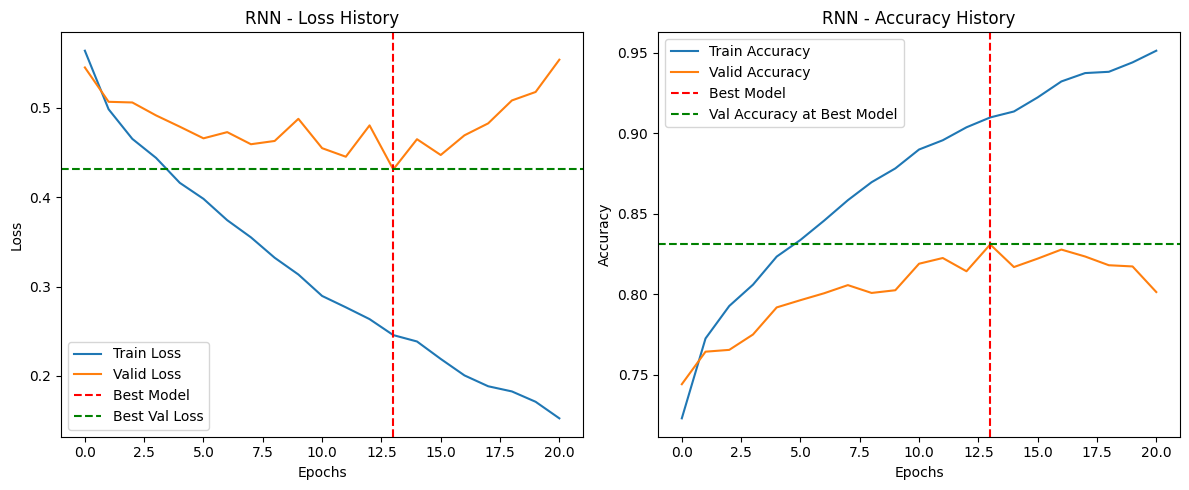

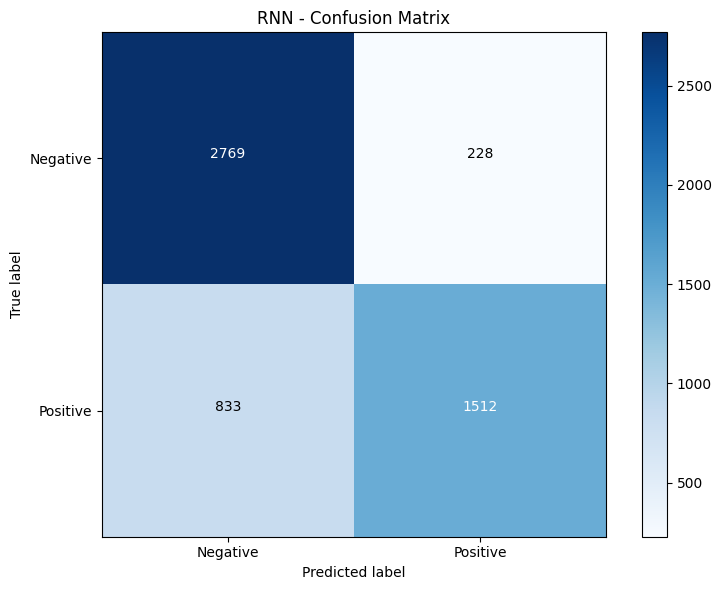

In [ ]:
# Plotting hasil pelatihan
plot_training_history(history_birnn_pt, "Bidirectional RNN")

# Plotting confusion matrix
y_pred_birnn_pt = np.array(result_birnn_pt['y_pred']).astype(int)
plot_confusion_matrix(y_test, y_pred_birnn_pt, "Bidirctional RNN")

### 5. Menyimpan Model

In [ ]:
# Menyimpan model
#torch.save(model_birnn.state_dict(), 'model_pytorch_birnn.pth')
#print("Model Bidirectional RNN disimpan sebagai 'model_pytorch_birnn.pth'")

## B. Model Deep RNN Menggunakan PyTorch

### 1. Menyusun Model Deep RNN


In [ ]:
# Definisi Model RNN
class DRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(DRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim, batch_first=True, num_layers=7)
        self.rnn2 = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=7)
        self.rnn3 = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=7)
        self.rnn4 = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=7)
        self.rnn5 = nn.RNN(hidden_dim, hidden_dim // 2, batch_first=True, num_layers=7)
            
        self.fc = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):
        embedded = self.embedding(text)
        
        output1, hidden1 = self.rnn1(embedded)
        output2, hidden2 = self.rnn2(output1)
        output3, hidden3 = self.rnn3(output2)
        output4, hidden4 = self.rnn4(output3)
        output5, hidden5 = self.rnn5(output4)
        hidden = hidden5[-1, :, :]
            
        dropout_out = self.dropout(hidden)
        return torch.sigmoid(self.fc(dropout_out))

# Inisialisasi model
model_drnn_pt = DRNNModel(
        vocab_size=NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM
    ).to(DEVICE)

### 2. Melatih Model

In [ ]:
# Loss function dan optimizer
criterion = nn.BCELoss()
optimizer_drnn = optim.Adam(model_drnn_pt.parameters(), lr=LEARNING_RATE)

# Melatih model RNN
print("Melatih model RNN...")
history_drnn_pt = train_model_pt(model_drnn_pt, train_loader, criterion, optimizer_drnn, DEVICE, epochs=EPOCHS, model_name='rnn')

Melatih model RNN...
Epoch: 1/25, Loss: 0.5641, Accuracy: 0.7229, Val Loss: 0.5454, Val Accuracy: 0.7441
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.5454)
Epoch: 2/25, Loss: 0.4986, Accuracy: 0.7725, Val Loss: 0.5069, Val Accuracy: 0.7643
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.5069)
Epoch: 3/25, Loss: 0.4654, Accuracy: 0.7927, Val Loss: 0.5062, Val Accuracy: 0.7654
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.5062)
Epoch: 4/25, Loss: 0.4442, Accuracy: 0.8060, Val Loss: 0.4917, Val Accuracy: 0.7750
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.4917)
Epoch: 5/25, Loss: 0.4162, Accuracy: 0.8234, Val Loss: 0.4791, Val Accuracy: 0.7918
Checkpoint: Model disimpan sebagai 'model_pytorch_rnn.pth' (validation loss terendah = 0.4791)
Epoch: 6/25, Loss: 0.3983, Accuracy: 0.8338, Val Loss: 0.4660, Val Accuracy: 0.7963


### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [ ]:
# Evaluasi model RNN
result_drnn_pt = evaluate_model_pt(model_drnn_pt, test_loader, criterion, DEVICE)
print("Evaluasi model RNN selesai.")
print(f"Loss: {result_drnn_pt['loss']:.4f}")
print(f"Accuracy: {result_drnn_pt['accuracy']:.4f}")
print(f"Precision: {result_drnn_pt['precision']:.4f}")
print(f"Recall: {result_drnn_pt['recall']:.4f}")
print(f"F1 Score: {result_drnn_pt['f1']:.4f}")
print(f"AUC: {result_drnn_pt['auc']:.4f}")

Evaluasi model RNN selesai.
Loss: 0.5540
Accuracy: 0.8014
Precision: 0.8690
Recall: 0.6448
F1 Score: 0.7403
AUC: 0.8989


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

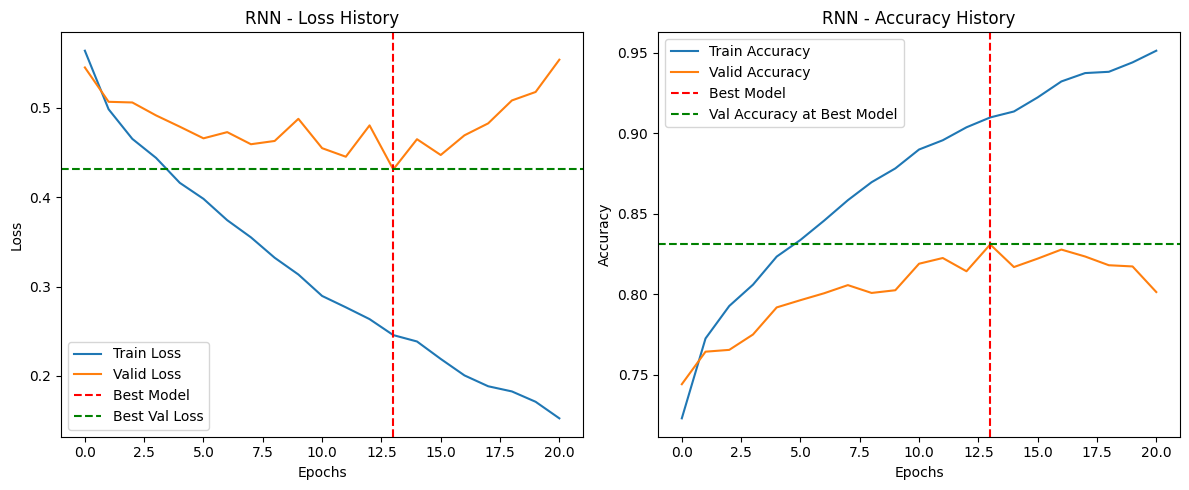

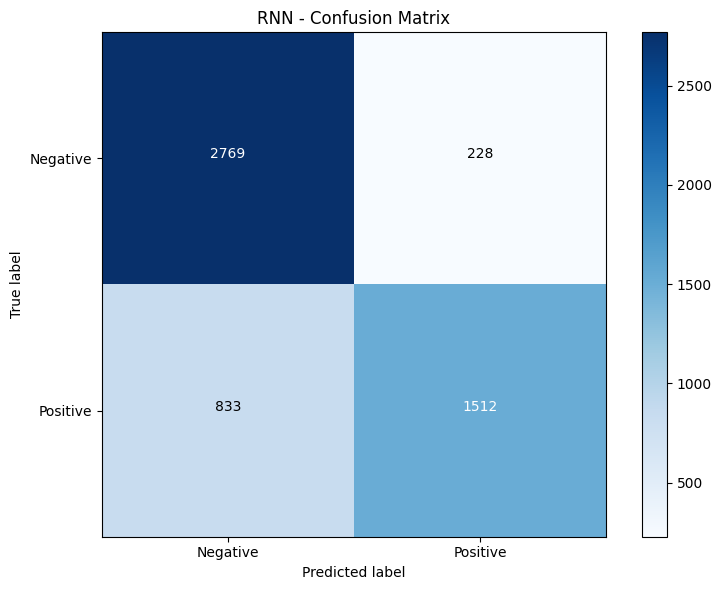

In [ ]:
# Plotting hasil pelatihan
plot_training_history(history_drnn_pt, "RNN")

# Plotting confusion matrix
y_pred_drnn_pt = np.array(result_drnn_pt['y_pred']).astype(int)
plot_confusion_matrix(y_test, y_pred_drnn_pt, "RNN")

### 5. Menyimpan Model

In [ ]:
# Menyimpan model
#torch.save(model_drnn.state_dict(), 'model_pytorch_drnn.pth')
#print("Model Deep RNN disimpan sebagai 'model_pytorch_drnn.pth'")

# Model DeteksiSarkasme Menggunakan Module TensorFlow

## A. Model Bidirectional RNN Menggunakan TensorFlow

### 1. Menyusun Model Bidirectional RNN


In [ ]:
# Fungsi untuk membuat model RNN kompleks
def build_birnn_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),
        
        Bidirectional(SimpleRNN(HIDDEN_DIM, return_sequences=True)),
        Bidirectional(SimpleRNN(HIDDEN_DIM // 2, return_sequences=False)),
        Dropout(DROPOUT_RATE),
        
        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_birnn_tf = build_birnn_model()

### 2. Melatih Model

In [ ]:
# Menyusun model
model_birnn_tf.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model RNN
print("Melatih model RNN...")
history_birnn_tf = train_model_tf(model_birnn_tf, (X_train_pad, y_train), 'birnn')

Melatih model RNN...
Memulai pelatihan model rnn...
Epoch 1/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7449 - loss: 0.5399 - val_accuracy: 0.8596 - val_loss: 0.3431
Epoch 2/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9228 - loss: 0.2252 - val_accuracy: 0.8613 - val_loss: 0.3562
Epoch 3/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9676 - loss: 0.1050 - val_accuracy: 0.8580 - val_loss: 0.3661
Epoch 4/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9807 - loss: 0.0597 - val_accuracy: 0.8505 - val_loss: 0.8207
Epoch 5/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9862 - loss: 0.0433 - val_accuracy: 0.8332 - val_loss: 0.6231
Epoch 6/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9851 - loss: 0.0524 - val_accuracy: 0.8453 - val_loss: 0.5998
Waktu pelatihan: 0m 47s


### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [ ]:
# Evaluasi model RNN
result_birnn_tf = evaluate_model_tf(model_birnn_tf, test_data, 'birnn')

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Evaluasi Model rnn:
Accuracy: 0.8607
Precision: 0.8417
Recall: 0.8409
F1 Score: 0.8413
AUC: 0.9298


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

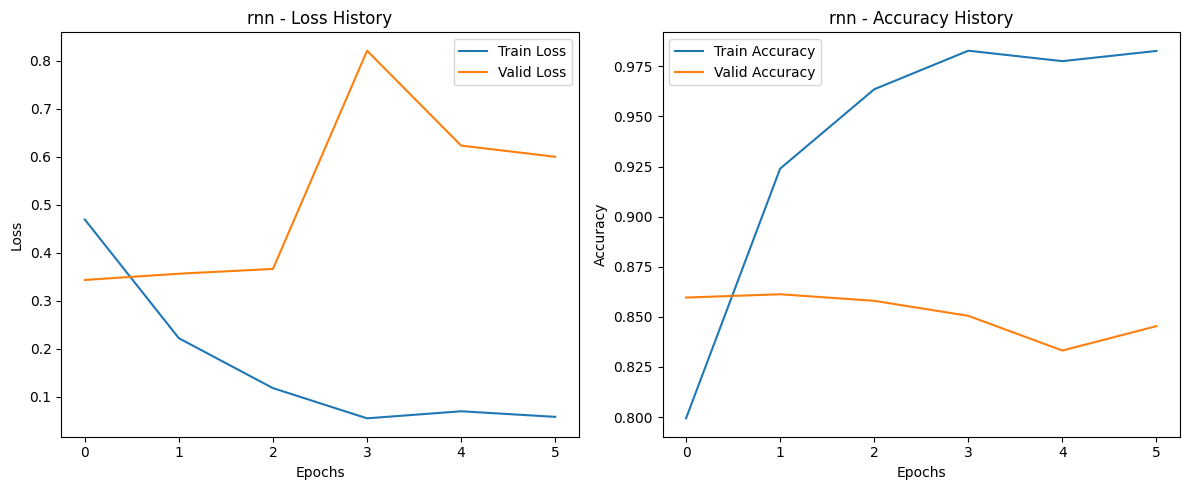

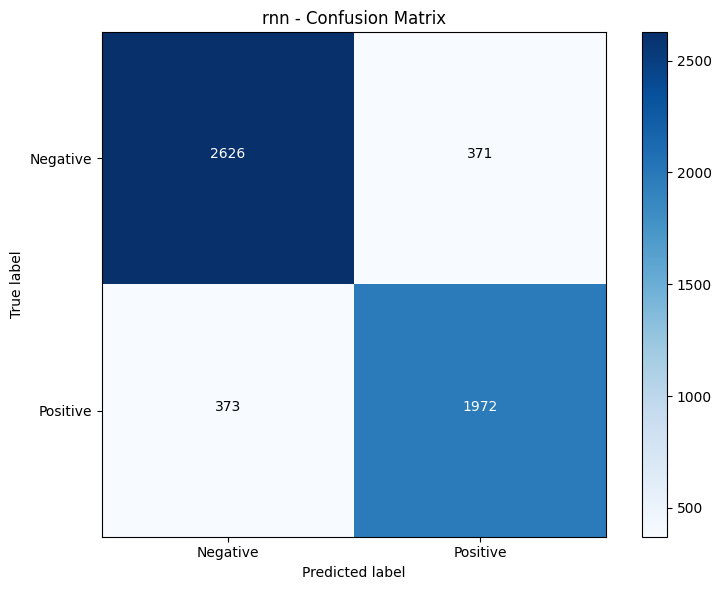

In [ ]:
# Plotting hasil pelatihan
plot_training_history(history_birnn_tf.history, "birnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_birnn_tf['y_pred'], "birnn")

### 5. Menyimpan Model

In [ ]:
# Menyimpan model
model_birnn_tf.save('model_tensorflow_birnn.keras')
print("Model RNN disimpan sebagai 'model_tensorflow_birnn.keras'")

Model RNN disimpan sebagai 'model_rnn.keras'


## A. Model Deep RNN Menggunakan TensorFlow

### 1. Menyusun Model Deep RNN


In [ ]:
# Fungsi untuk membuat model RNN kompleks
def build_drnn_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),
        
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM // 2, return_sequences=False),
        Dropout(DROPOUT_RATE),
        
        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_drnn_tf = build_birnn_model()

### 2. Melatih Model

In [ ]:
# Menyusun model
model_drnn_tf.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model RNN
print("Melatih model RNN...")
history_drnn_tf = train_model_tf(model_drnn_tf, (X_train_pad, y_train), 'drnn')

Melatih model RNN...
Memulai pelatihan model rnn...
Epoch 1/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7449 - loss: 0.5399 - val_accuracy: 0.8596 - val_loss: 0.3431
Epoch 2/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9228 - loss: 0.2252 - val_accuracy: 0.8613 - val_loss: 0.3562
Epoch 3/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9676 - loss: 0.1050 - val_accuracy: 0.8580 - val_loss: 0.3661
Epoch 4/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9807 - loss: 0.0597 - val_accuracy: 0.8505 - val_loss: 0.8207
Epoch 5/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9862 - loss: 0.0433 - val_accuracy: 0.8332 - val_loss: 0.6231
Epoch 6/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9851 - loss: 0.0524 - val_accuracy: 0.8453 - val_loss: 0.5998
Waktu pelatihan: 0m 47s


### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [ ]:
# Evaluasi model RNN
result_drnn_tf = evaluate_model_tf(model_drnn_tf, test_data, 'birnn')

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Evaluasi Model rnn:
Accuracy: 0.8607
Precision: 0.8417
Recall: 0.8409
F1 Score: 0.8413
AUC: 0.9298


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

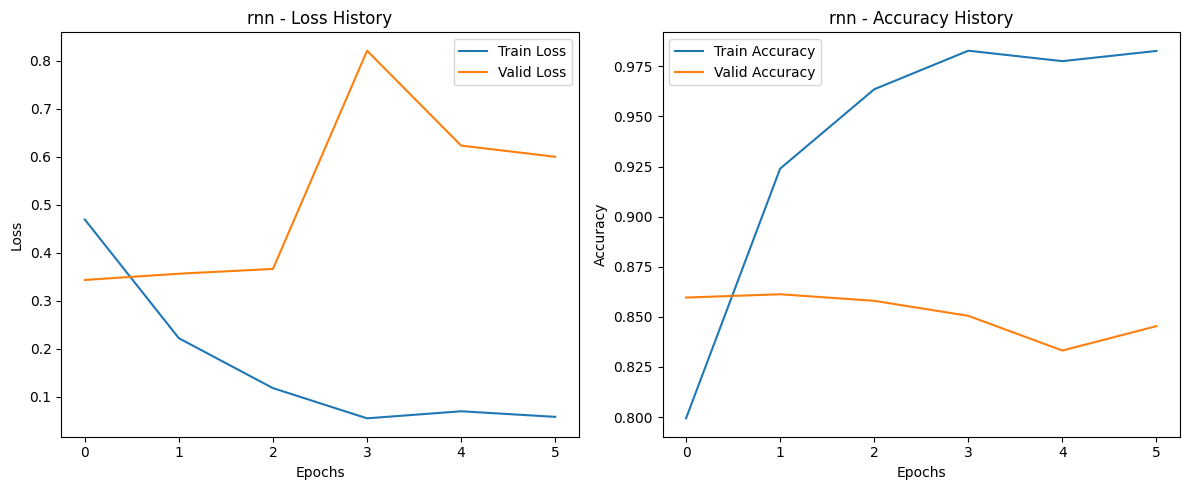

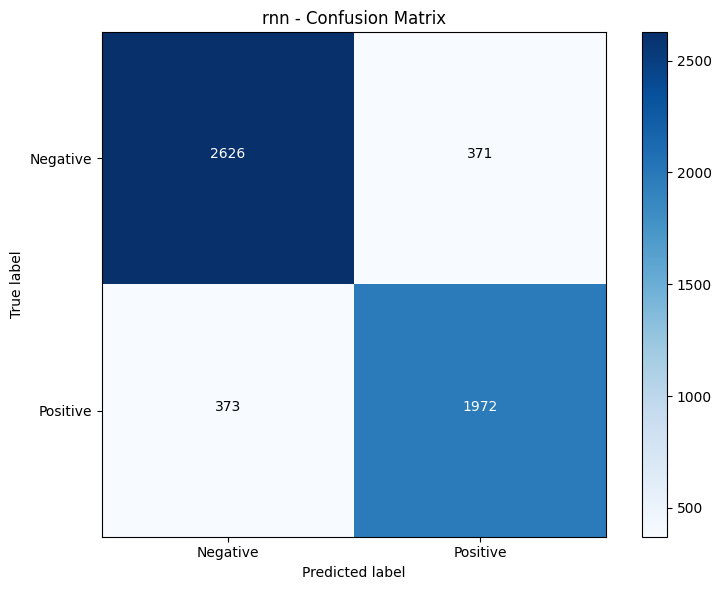

In [ ]:
# Plotting hasil pelatihan
plot_training_history(history_drnn_tf.history, "birnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_drnn_tf['y_pred'], "birnn")

### 5. Menyimpan Model

In [ ]:
# Menyimpan model
model_birnn_tf.save('model_tensorflow_drnn.keras')
print("Model RNN disimpan sebagai 'model_tensorflow_drnn.keras'")

Model RNN disimpan sebagai 'model_rnn.keras'
